## Load Modules

In [1]:
from xmitgcm import open_mdsdataset
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
from matplotlib import pyplot as plt 
from scipy import interpolate
import warnings; warnings.simplefilter('ignore')
from numba import jit

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile, AdvectionRK4_3D, ErrorCode
import math
from datetime import timedelta
from operator import attrgetter

from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:33361 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 9 Cores: 72 Memory: 134.72 GB


## Create a xarray dataset from MITgcm

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,10)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = False

run = 'ridge0.15relax'


plot_dir = '/glade/u/home/myoungs/Figures/'+datetime.date.today().isoformat()+'/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

#for x in run:
    ## read in data #######
      
#data_dir = '/glade/p/univ/umit0025/particle_tracking/'+run
data_dir = '/glade/p/univ/umit0025/newbuoyancy/'+run

print(data_dir)
    
   
ds = open_mdsdataset(data_dir,prefix=['DIAG','DIAGLayer','DIAGSurf'],delta_t=600)
#ds =  open_mdsdataset(data_dir,prefix=['DIAGLayer','DIAG'],delta_t=600)
#                        # ignore_unknown_vars==True)#,iters='377225') # ,'DIAGTracer'
grid = xgcm.Grid(ds, periodic=['X'])
#gridmean = xgcm.Grid(dsmean, periodic=['X'])
ds

/glade/p/univ/umit0025/newbuoyancy/ridge0.15relax


<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 204, YG: 204, Z: 32, Zl: 32, Zp1: 33, Zu: 32, layer_1TH_bounds: 50, layer_1TH_center: 49, layer_1TH_interface: 48, time: 20)
Coordinates:
  * XC                   (XC) >f4 5000.0 15000.0 25000.0 ... 3985000.0 3995000.0
  * YC                   (YC) >f4 5000.0 15000.0 25000.0 ... 2025000.0 2035000.0
  * XG                   (XG) >f4 0.0 10000.0 20000.0 ... 3980000.0 3990000.0
  * YG                   (YG) >f4 0.0 10000.0 20000.0 ... 2020000.0 2030000.0
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 ... -3300.0 -3580.0 -3860.0
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 ... -3440.0 -3720.0 -4000.0
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 ... -3440.0 -3720.0 -4000.0
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 ... -3160.0 -3440.0 -3720.0
    rA                   (YC, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dxG                  (YG, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dyG                  (YC, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    Depth                (YC, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    rAz                  (YG, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dxC                  (YC, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    dyC                  (YG, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    rAw                  (YC, XG) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    rAs                  (YG, XC) >f4 dask.array<chunksize=(204, 400), meta=np.ndarray>
    drC                  (Zp1) >f4 dask.array<chunksize=(33,), meta=np.ndarray>
    drF                  (Z) >f4 dask.array<chunksize=(32,), meta=np.ndarray>
    PHrefC               (Z) >f4 dask.array<chunksize=(32,), meta=np.ndarray>
    PHrefF               (Zp1) >f4 dask.array<chunksize=(33,), meta=np.ndarray>
    hFacC                (Z, YC, XC) >f4 dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    hFacW                (Z, YC, XG) >f4 dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    hFacS                (Z, YG, XC) >f4 dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    maskC                (Z, YC, XC) bool dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    maskW                (Z, YC, XG) bool dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
    maskS                (Z, YG, XC) bool dask.array<chunksize=(32, 204, 400), meta=np.ndarray>
  * layer_1TH_bounds     (layer_1TH_bounds) >f4 0.0 0.1632653 ... 7.836735 8.0
  * layer_1TH_center     (layer_1TH_center) float32 0.08163265 ... 7.9183674
  * layer_1TH_interface  (layer_1TH_interface) >f4 0.1632653 ... 7.836735
    iter                 (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time                 (time) int64 24125040000 24282720000 ... 27120960000
Data variables:
    THETA                (time, Z, YC, XC) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    VVELMASS             (time, Z, YG, XC) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    UVEL                 (time, Z, YC, XG) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    VVEL                 (time, Z, YG, XC) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    UVELSQ               (time, Z, YC, XG) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    VVELSQ               (time, Z, YG, XC) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    VVELTH               (time, Z, YG, XC) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    UV_VEL_Z             (time, Z, YG, XG) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    WVEL                 (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndarray>
    WVELTH               (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 32, 204, 400), meta=np.ndar

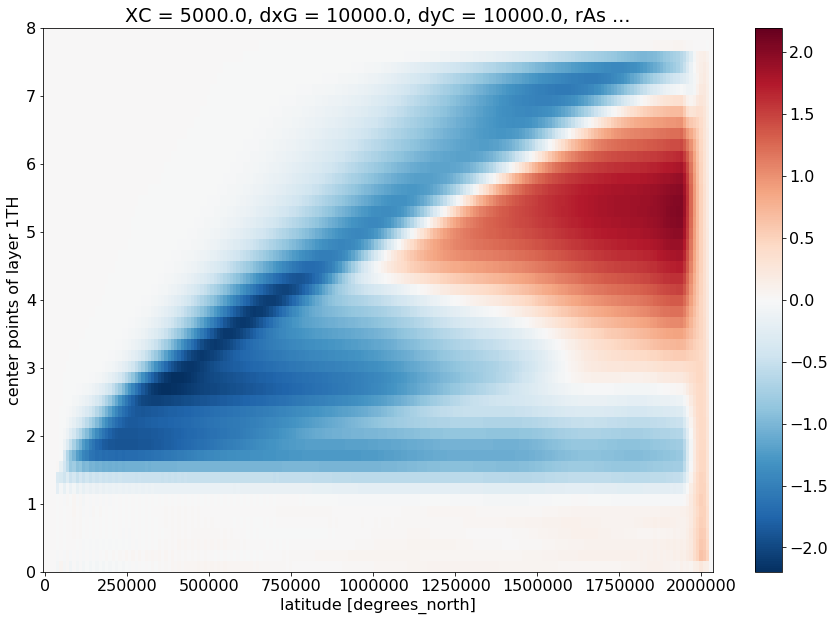

In [3]:
psi = -ds.dxG[0,0]*ds.LaVH1TH.sum(dim='XC').cumsum(dim='layer_1TH_center')/1e6
MeanPsi = -ds.dxG[0,0]*(ds.LaVa1TH.mean(dim='time')*ds.LaHs1TH.mean(dim='time')).sum(dim='XC').cumsum(dim='layer_1TH_center')/1e6
psiMean = psi.mean(dim='time')

psiMean.plot()

In [4]:
psicontour = np.array(psiMean[10:40,190])
f = interpolate.interp1d(psicontour,np.array(ds.layer_1TH_center[10:40]))
celldiv = f(0)
uppersplit = f(np.max(psicontour))
lowersplit = f(np.min(psicontour))



#psiMean.plot()
print(celldiv)
print(uppersplit)
print(lowersplit)

2.6854351857233745
5.3061223
1.7142857


## Load data

In [41]:
dst = xr.open_dataset('/glade/p/univ/umit0025/particle_tracking/10day_res.nc',decode_times=False)#,chunks={'traj': 1000})
#dst = xr.open_dataset('/glade/p/univ/umit0025/particle_tracking/10DayGrid1yr.nc',decode_times=False)#,chunks={'traj': 1000})

In [42]:
for tra in range(np.shape(dst.time)[0]):
    if ~np.isnan(dst.lon[tra,-1]):
            dst.lon[tra] = np.nan
            dst.lat[tra] = np.nan
            dst.t[tra] = np.nan
            dst.z[tra] = np.nan
            dst.time[tra] = np.nan
            dst.meandisp[tra] = np.nan
            dst.totdisp[tra] = np.nan
            dst.btdisp[tra] = np.nan
            dst.meanbtdisp[tra] = np.nan

# Write a function that sorts based on x, y, tempbin, instance
## initialize grid

In [43]:
delta = 0.5
temps = np.arange(0,5,delta)
dd =  xr.Dataset(coords={'lon': (['x'], ds.XC[range(0,400,10)]),
                             'lat': (['y'], ds.YC[range(0,200,10)]),
                            'temp': (['T'],temps)})



dd2 =  xr.Dataset(coords={'lon': (['x'], ds.XC[range(0,400,10)]),
                             'lat': (['y'], ds.YC[range(0,200,10)]),
                            'depth': (['z'],ds.Z)})

dd2


@jit(nopython=True,parallel=True)
def lastdisp(displacement,temps,lats,lons,lat,lon,temp,delta,deltax):
    outdisp = np.empty((len(temp),20,40))
    outdisp.fill(np.nan)
    for k in range(len(temp)):
        print(temp[k])
        for i in range(40):
            for j in range(20):
                mask = np.ones(np.shape(displacement))
                mask[temps>temp[k]+delta] = np.nan
                mask[temps<temp[k]] = np.nan
                mask[lats >= lat[j]+deltax/2] = np.nan 
                mask[lats < lat[j]-deltax/2] = np.nan
                mask[lons >= lon[i]+deltax/2] = np.nan
                mask[lons < lon[i]-deltax/2] = np.nan
                # sort through the ones that remain to find the one with the maximum time here, aka the last time, make sure it is actually doing what I want it to do
              #  mask[times < np.max(times,dim)] = np.nan
    #disp = ds1.totdisp.dropna(dim='obs').where(temps<temp+delta).where(ds1.t[:,1]>temp).where(ds1.lon[:,0]==lon).where(ds1.lat[:,0]==lat)
                outdisp[k,j,i] = np.nanmean(displacement*mask)
    #            lasttime[k,j,i] = np.nanmean()
    return outdisp

def dispInZ(displacement,zs,lats,lons,lat,lon,z,delta,deltax):
    outdisp = np.empty((32,20,40))
    outdisp.fill(np.nan)
    for k in range(32):
        print(z[k])
        for i in range(40):
            for j in range(20):
                mask = np.ones(np.shape(displacement))
                mask[zs != z[k]] = np.nan
                mask[lats >= lat[j]+deltax/2] = np.nan 
                mask[lats < lat[j]-deltax/2] = np.nan
                mask[lons >= lon[i]+deltax/2] = np.nan
                mask[lons < lon[i]-deltax/2] = np.nan
    #disp = ds1.totdisp.dropna(dim='obs').where(temps<temp+delta).where(ds1.t[:,1]>temp).where(ds1.lon[:,0]==lon).where(ds1.lat[:,0]==lat)
                outdisp[k,j,i] = np.nanmean(displacement*mask)
    return outdisp

## Loop through temps and x,y positions

In [44]:
disps = np.array(dst.totdisp.where(dst.time == dst.time.max(dim='obs')))
meandisps = np.array(dst.meandisp.where(dst.time == dst.time.max(dim='obs')))
#btdisps = np.array(dst.btdisp.where(dst.time == dst.time.max(dim='obs')))
#meanbtdisps = np.array(dst.meanbtdisp.where(dst.time == dst.time.max(dim='obs')))


vels = np.array(dst.totdisp.where(dst.time == dst.time.max(dim='obs')))#/(dst.time.max(dim='obs')-dst.time[:,0]))
meanvels = np.array(dst.meandisp.where(dst.time == dst.time.max(dim='obs')))#/(dst.time.max(dim='obs')-dst.time[:,0]))
#btvels = np.array(dst.btdisp.where(dst.time == dst.time.max(dim='obs')))#/(dst.time.max(dim='obs')-dst.time[:,0]))
#meanbtvels = np.array(dst.meanbtdisp.where(dst.time == dst.time.max(dim='obs')))#/(dst.time.max(dim='obs')-dst.time[:,0]))

inputdisp = disps[~np.isnan(disps)]
meaninputdisp = meandisps[~np.isnan(meandisps)]
#btinputdisp = btdisps[~np.isnan(btdisps)]
#meanbtinputdisp = meanbtdisps[~np.isnan(meanbtdisps)]

inputvels = vels[~np.isnan(vels)]
meaninputvels = meanvels[~np.isnan(meanvels)]
#btinputvels = btvels[~np.isnan(btvels)]
#meanbtinputvels = meanbtvels[~np.isnan(meanbtvels)]

intemps = np.array(dst.t*0+dst.t[:,1])
intemps = intemps[~np.isnan(disps)]
inlats = np.array(dst.lat)
inlats = inlats[~np.isnan(disps)]
inlons = np.array(dst.lon)
inlons = inlons[~np.isnan(disps)]
inzs = np.array(dst.z*0 + dst.z[:,0])
inzs = inzs[~np.isnan(disps)]
intimes = np.array(dst.time - dst.time[:,0])
intimes = intimes[~np.isnan(disps)]

#dd.totaldisp = xr.apply_ufunc(lastdisp,inputdisp,dst.t[:,1],dst.lat[:,0],dst.lon[:,0],dd.lon,dd.lat,dd.temp,dask='parallelized')


#xlocs = dst.lon.where(dst.t[:,1]<3).where(dst.t[:,1]>2.5)
#ylocs = dst.lat.where(dst.t[:,1]<3).where(dst.t[:,1]>2.5)
#plt.scatter(xlocs[:,0],ylocs[:,0],c=disps)
dx = 100000

dd['totaldisp'] = (('T', 'y', 'x'), lastdisp(inputdisp,intemps,inlats,inlons,np.array(np.double(dd.lat)),np.array(np.double(dd.lon)),np.array(dd.temp),delta,dx))
dd['meandisp'] = (('T', 'y', 'x'), lastdisp(meaninputdisp,intemps,inlats,inlons,np.array(np.double(dd.lat)),np.array(np.double(dd.lon)),np.array(dd.temp),delta,dx))
#dd['btdisp'] = (('T', 'y', 'x'), lastdisp(btinputdisp,intemps,inlats,inlons,np.array(np.double(dd.lat)),np.array(np.double(dd.lon)),np.array(dd.temp),delta,dx))
#dd['meanbtdisp'] = (('T', 'y', 'x'), lastdisp(meanbtinputdisp,intemps,inlats,inlons,np.array(np.double(dd.lat)),np.array(np.double(dd.lon)),np.array(dd.temp),delta,dx))

#dd2['totaldisp'] = (('z', 'y', 'x'), dispInZ(inputvels,inzs,inlats,inlons,np.array(np.double(dd2.lat)),np.array(np.double(dd2.lon)),np.array(np.double(dd2.depth)),delta,dx))
#dd2['meandisp'] = (('z', 'y', 'x'), dispInZ(meaninputvels,inzs,inlats,inlons,np.array(np.double(dd2.lat)),np.array(np.double(dd2.lon)),np.array(np.double(dd2.depth)),delta,dx))
#dd2['btdisp'] = (('z', 'y', 'x'), dispInZ(btinputvels,inzs,inlats,inlons,np.array(np.double(dd2.lat)),np.array(np.double(dd2.lon)),np.array(np.double(dd2.depth)),delta,dx))
#dd2['meanbtdisp'] = (('z', 'y', 'x'), dispInZ(meanbtinputvels,inzs,inlats,inlons,np.array(np.double(dd2.lat)),np.array(np.double(dd2.lon)),np.array(np.double(dd2.depth)),delta,dx))

0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
0.0
0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5


In [45]:
num = np.shape(intimes)

In [ ]:
#plt.figure()
plt.plot(inputdisp)


plt.figure()
dd.totaldisp.mean(dim='x').plot(vmin=-5,vmax=5,cmap='bwr')
#plt.xlabel('Y (km)')
plt.yticks(range(0,np.size(temps),2),[0, 1 ,2,3,4,5])
plt.xticks([0,5, 10,15, 20],[0, 500, 1000,1500, 2000])
plt.ylabel('Temperature (C)')

plt.figure()
dd.meandisp.mean(dim='x').plot(vmin=-5,vmax=5,cmap='bwr')
#plt.xlabel('Y (km)')
plt.xticks([0,5, 10,15, 20],[0, 500, 1000,1500, 2000])
plt.yticks(range(0,np.size(temps),2),[0, 1 ,2,3,4,5])
plt.ylabel('Temperature (C)')


plt.figure()
(dd.totaldisp-dd.meandisp).mean(dim='x').plot(vmin=-5,vmax=5,cmap='bwr')
plt.xlabel('Y (km)')
plt.xticks([0,5, 10,15, 20],[0, 500, 1000,1500, 2000])
plt.yticks(range(0,np.size(temps),2),[0, 1 ,2,3,4,5])
plt.ylabel('Temperature (C)')

plt.figure()
plt.plot(range(0,2000,100),dd2.meandisp[15].mean(dim='x'))
plt.plot(ds.YC[6:]/1000,ds.WVEL[:,15,6:].mean(dim=['XC','time']))
plt.grid()
plt.xlabel('Y (km)')
plt.ylabel('w (m/s)')
plt.legend(['w from particles','w from MITgcm'])

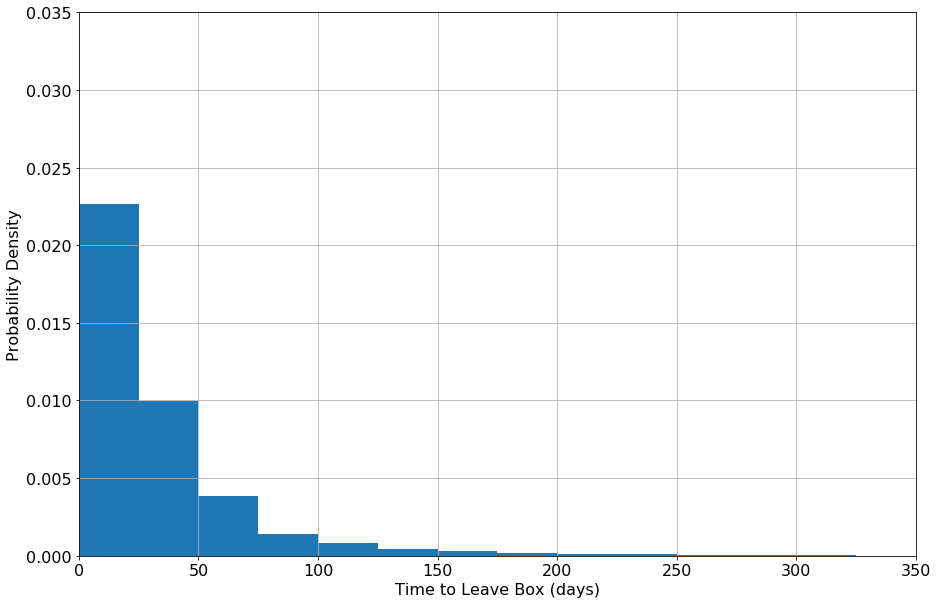

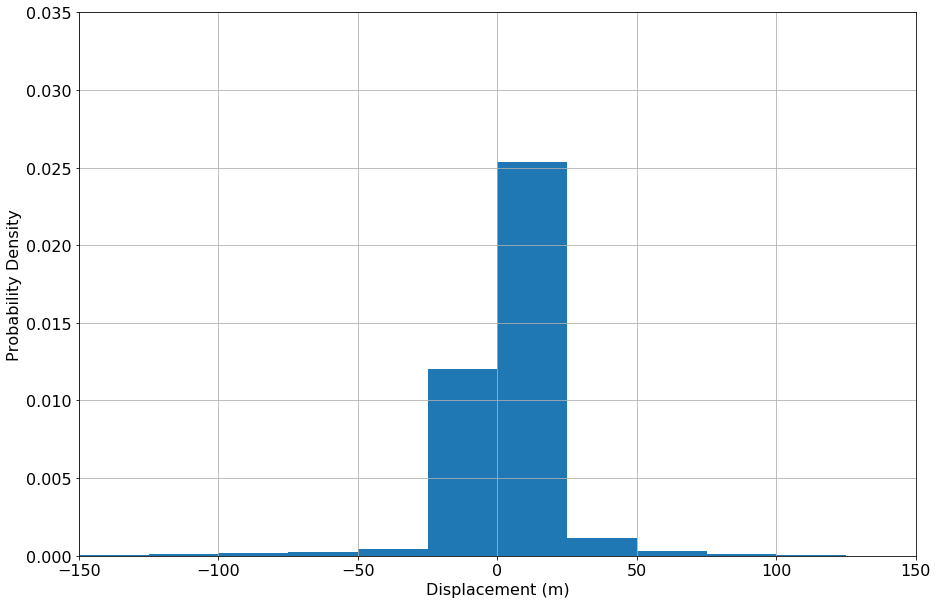

In [47]:

plt.figure()
plt.hist(intimes/3600/24,density=True,bins=np.arange(0,350,25))
plt.xlabel('Time to Leave Box (days)')
plt.xlim([0, 350])
plt.ylim([0, 0.035])
plt.ylabel('Probability Density')
plt.grid()

plt.figure()
plt.hist(inputdisp,density=True,bins = np.arange(-150,150,25))
plt.xlabel('Displacement (m)')
plt.ylabel('Probability Density')
plt.xlim([-150,150])
plt.ylim([0, 0.035])
plt.grid()

<Figure size 1080x720 with 0 Axes>

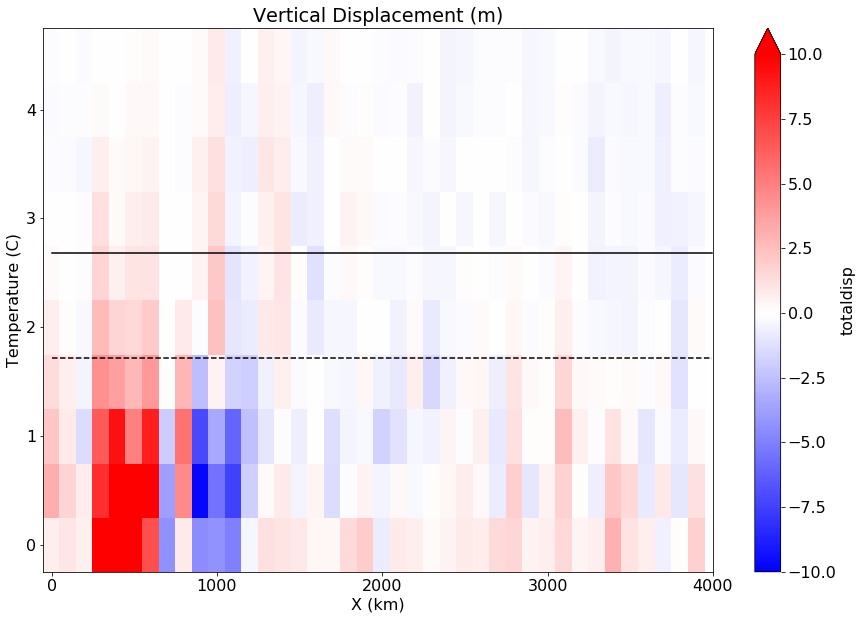

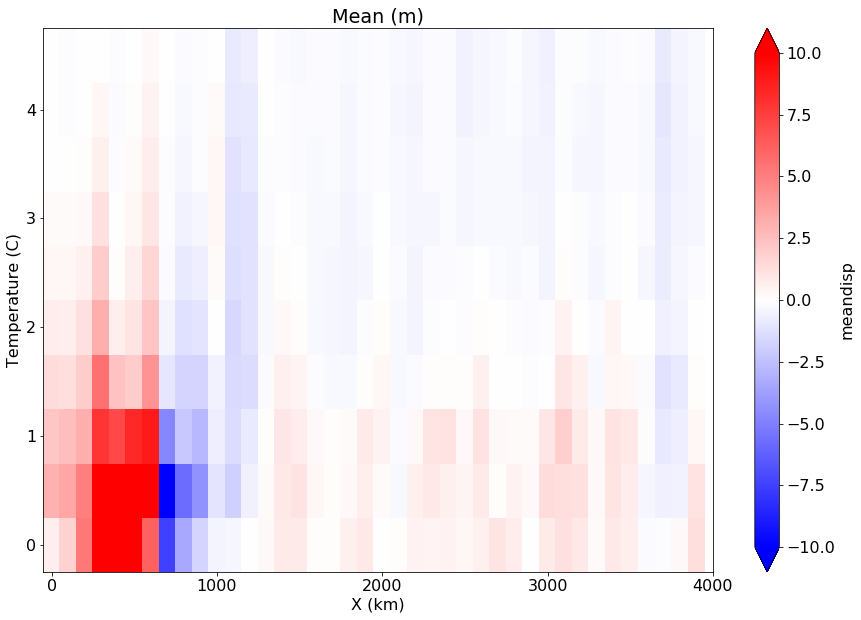

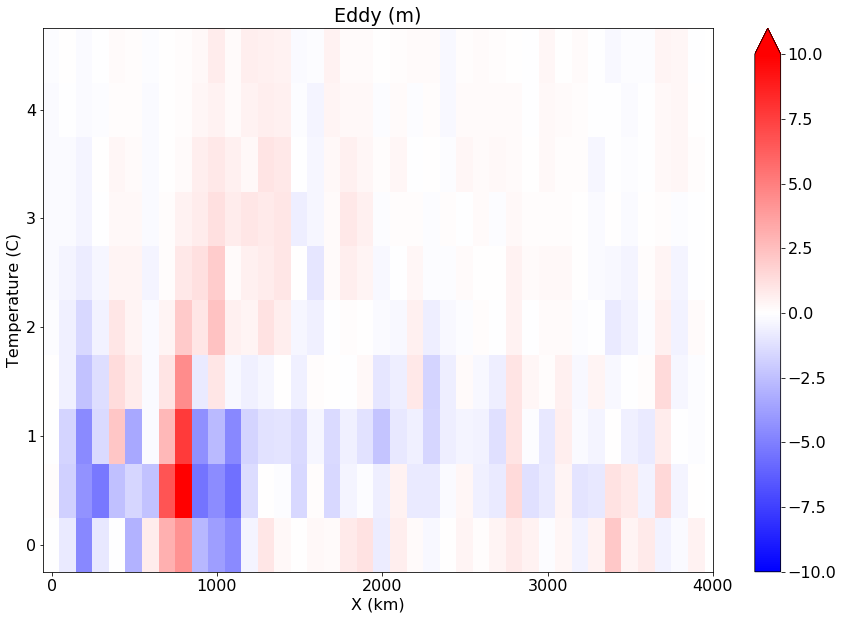

<Figure size 1080x720 with 0 Axes>

In [31]:
plt.figure()
(dd.totaldisp).mean(dim='y').plot(vmin=-10,vmax=10,cmap='bwr')
plt.yticks(range(0,np.size(temps),2),[0, 1 ,2,3,4,5])
plt.xticks([0,10,20,30, 40],[0, 1000, 2000, 3000, 4000])
plt.plot(ds.XC/100000,celldiv*np.ones(np.size(ds.XC))/delta,'k-')
plt.plot(ds.XC/100000,uppersplit*np.ones(np.size(ds.XC))/delta)
plt.plot(ds.XC/100000,lowersplit*np.ones(np.size(ds.XC))/delta,'k--')
plt.title('Vertical Displacement (m)')
plt.xlabel('X (km)')
plt.ylabel('Temperature (C)')


plt.figure()
(dd.meandisp).mean(dim='y').plot(vmin=-10,vmax=10,cmap='bwr')
plt.yticks(range(0,np.size(temps),2),[0, 1 ,2,3,4,5])
plt.xticks([0,10,20,30, 40],[0, 1000, 2000, 3000, 4000])
#plt.plot(ds.XC/100000,celldiv*np.ones(np.size(ds.XC))/delta)
#plt.plot(ds.XC/100000,uppersplit*np.ones(np.size(ds.XC))/delta)
#plt.plot(ds.XC/100000,lowersplit*np.ones(np.size(ds.XC))/delta)
plt.title('Mean (m)')
plt.xlabel('X (km)')
plt.ylabel('Temperature (C)')

plt.figure()
((dd.totaldisp-dd.meandisp)).mean(dim='y').plot(vmin=-10,vmax=10,cmap='bwr')
plt.yticks(range(0,np.size(temps),2),[0, 1 ,2,3,4,5])
plt.xticks([0,10,20,30, 40],[0, 1000, 2000, 3000, 4000])
#plt.plot(ds.XC/100000,celldiv*np.ones(np.size(ds.XC))/delta)
#plt.plot(ds.XC/100000,uppersplit*np.ones(np.size(ds.XC))/delta)
#plt.plot(ds.XC/100000,lowersplit*np.ones(np.size(ds.XC))/delta)
plt.title('Eddy (m)')
plt.xlabel('X (km)')
plt.ylabel('Temperature (C)')
#plt.figure()
#(data.geodisp*data.mask).mean(dim='YC').plot()


plt.figure()


AttributeError: 'Dataset' object has no attribute 'btdisp'

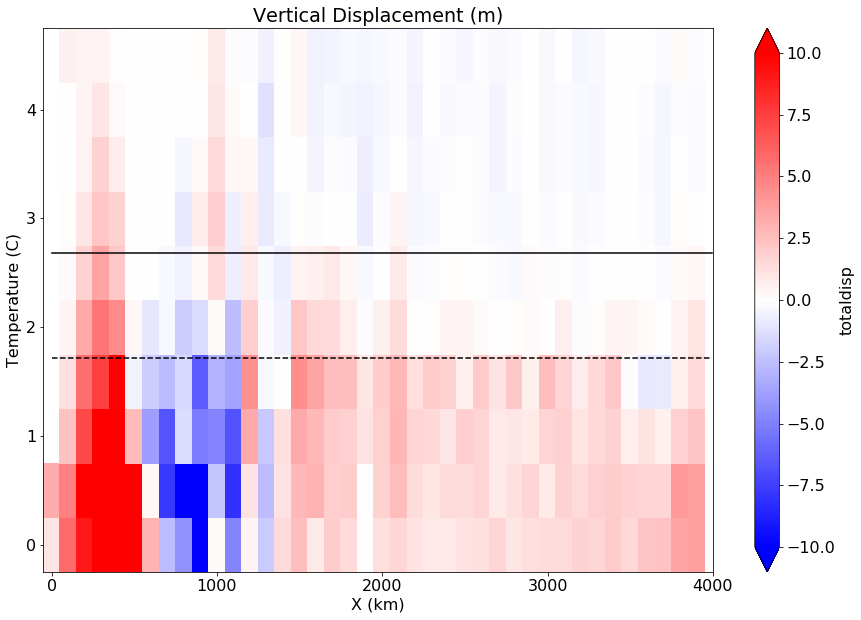

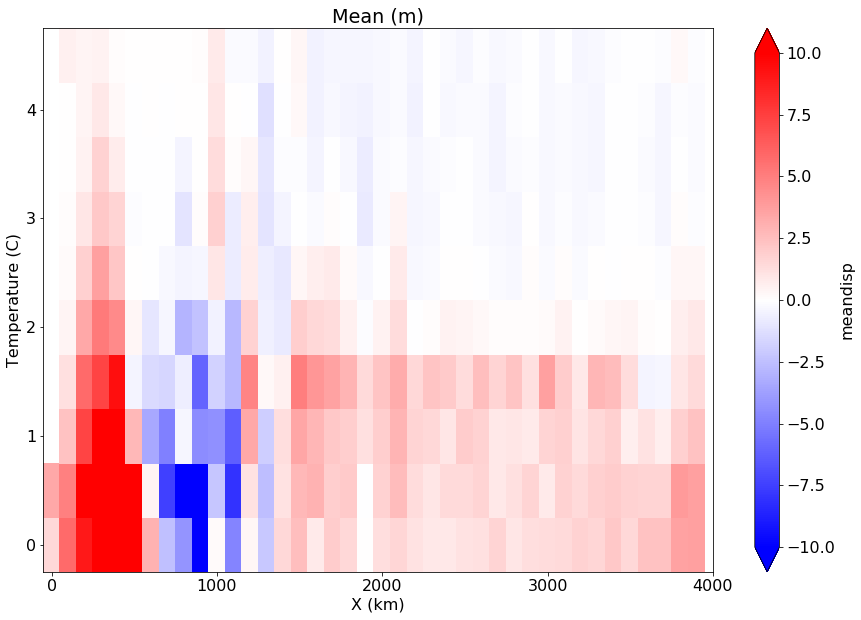

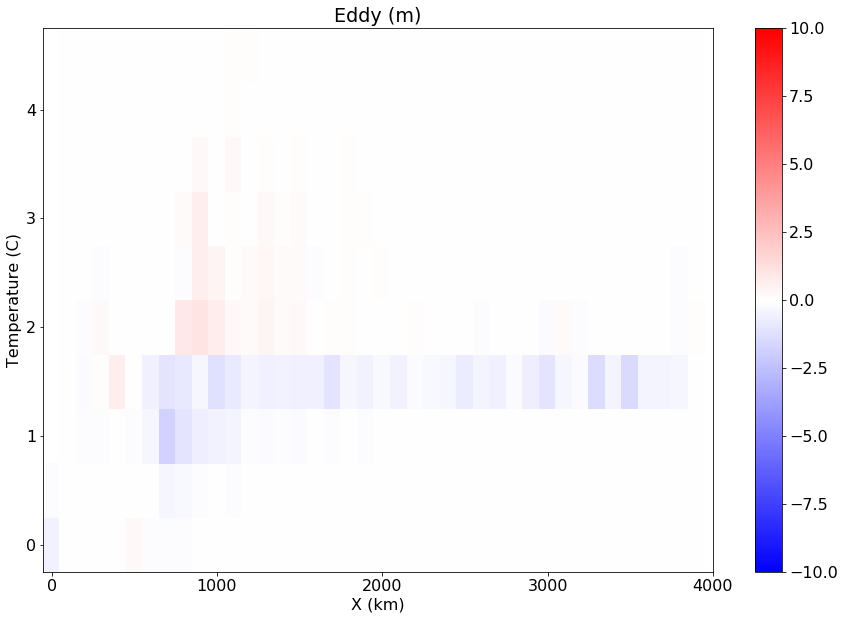

<Figure size 1080x720 with 0 Axes>

In [10]:
#plt.figure()
#((data.disp-data.geodisp)*data.mask).mean(dim='YC').plot()

plt.figure()
((dd.btdisp-dd.meanbtdisp)).mean(dim='y').plot(vmin=-5,vmax=5,cmap='bwr')
plt.yticks(range(0,np.size(temps),2),[0, 1 ,2,3,4,5])
plt.xticks([0,10,20,30, 40],[0, 1000, 2000, 3000, 4000])
#plt.plot(ds.XC/100000,celldiv*np.ones(np.size(ds.XC))/delta)
#plt.plot(ds.XC/100000,uppersplit*np.ones(np.size(ds.XC))/delta)
#plt.plot(ds.XC/100000,lowersplit*np.ones(np.size(ds.XC))/delta)
plt.title('Barotropic Eddy (m)')
plt.xlabel('X (km)')
plt.ylabel('Temperature (C)')

plt.figure()
(((dd.totaldisp-dd.meandisp)-(dd.btdisp-dd.meanbtdisp))).mean(dim='y').plot(vmin=-5,vmax=5,cmap='bwr')
plt.yticks(range(0,np.size(temps),2),[0, 1 ,2,3,4,5])
plt.xticks([0,10,20,30, 40],[0, 1000, 2000, 3000, 4000])
#plt.plot(ds.XC/100000,celldiv*np.ones(np.size(ds.XC))/delta)
#plt.plot(ds.XC/100000,uppersplit*np.ones(np.size(ds.XC))/delta)
#plt.plot(ds.XC/100000,lowersplit*np.ones(np.size(ds.XC))/delta)
plt.title('Baroclinic Eddy (m)')
plt.xlabel('X (km)')
plt.ylabel('Temperature (C)')

Text(0, 0.5, 'Displacement (m)')

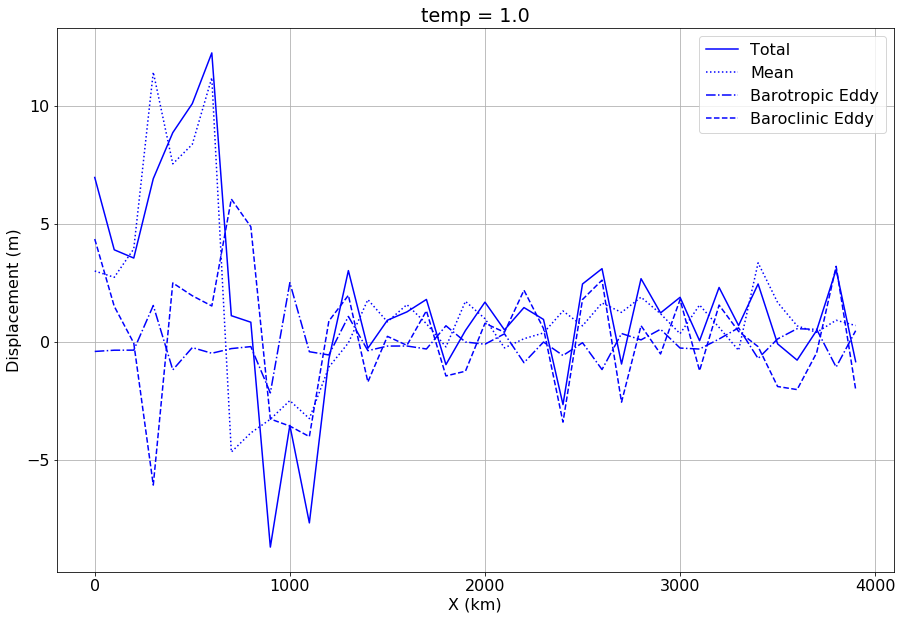

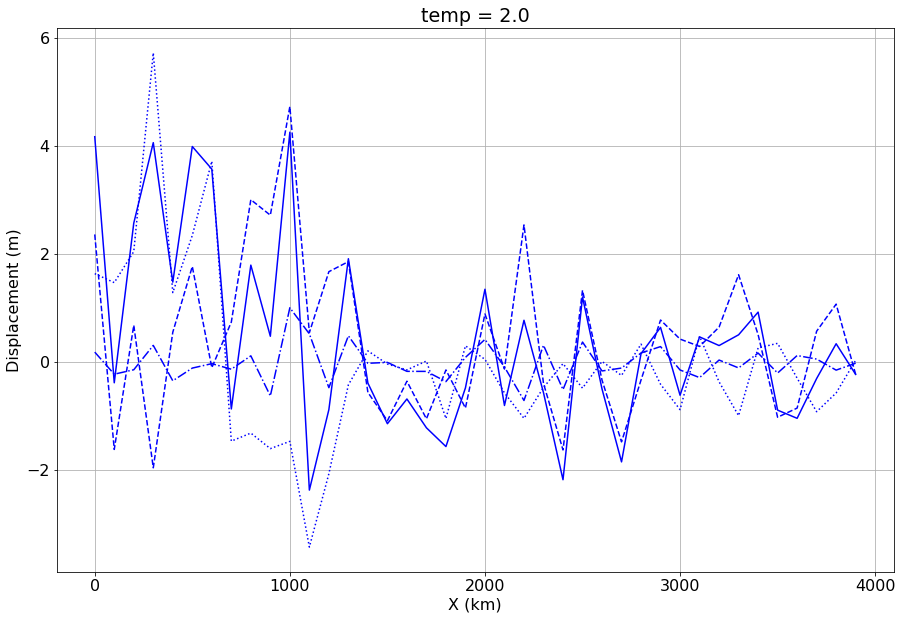

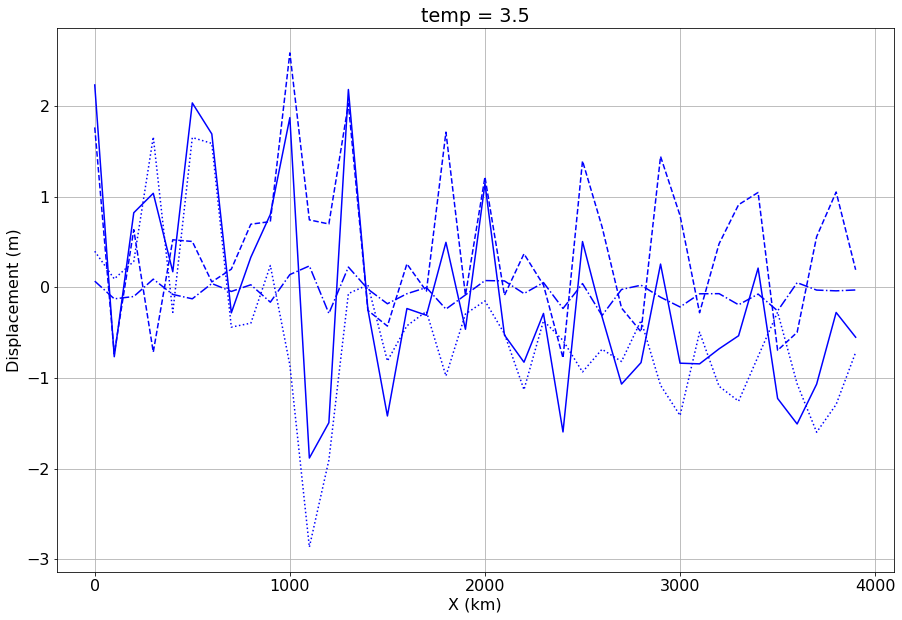

In [12]:
plt.figure()
plt.grid()

plt.xticks([0,10,20,30, 40],[0, 1000, 2000, 3000, 4000])
(dd.totaldisp[2]).mean(dim='y').plot(color='b',linestyle='-')
(dd.meandisp[2]).mean(dim='y').plot(color='b',linestyle=':')
((dd.btdisp[2]-dd.meanbtdisp[2])).mean(dim='y').plot(color='b',linestyle='-.')
(((dd.totaldisp[2]-dd.meandisp[2])-(dd.btdisp[2]-dd.meanbtdisp[2]))).mean(dim='y').plot(color='b',linestyle='--')
plt.legend(['Total','Mean','Barotropic Eddy','Baroclinic Eddy'])
plt.xlabel('X (km)')
plt.ylabel('Displacement (m)')
#plt.ylim([-250,300])

plt.figure()
plt.grid()
plt.xticks([0,10,20,30, 40],[0, 1000, 2000, 3000, 4000])
(dd.totaldisp[4]).mean(dim='y').plot(color='b',linestyle='-')
(dd.meandisp[4]).mean(dim='y').plot(color='b',linestyle=':')
((dd.btdisp[4]-dd.meanbtdisp[4])).mean(dim='y').plot(color='b',linestyle='-.')
(((dd.totaldisp[4]-dd.meandisp[4])-(dd.btdisp[4]-dd.meanbtdisp[4]))).mean(dim='y').plot(color='b',linestyle='--')
plt.xlabel('X (km)')
plt.ylabel('Displacement (m)')
#plt.ylim([-250,300])

plt.figure()
plt.grid()
plt.xticks([0,10,20,30, 40],[0, 1000, 2000, 3000, 4000])
(dd.totaldisp[7]).mean(dim='y').plot(color='b',linestyle='-')
(dd.meandisp[7]).mean(dim='y').plot(color='b',linestyle=':')
((dd.btdisp[7]-dd.meanbtdisp[7])).mean(dim='y').plot(color='b',linestyle='-.')
(((dd.totaldisp[7]-dd.meandisp[7])-(dd.btdisp[7]-dd.meanbtdisp[7]))).mean(dim='y').plot(color='b',linestyle='--')
plt.xlabel('X (km)')
plt.ylabel('Displacement (m)')
#plt.ylim([-250,300])

<xarray.DataArray 'totaldisp' ()>
array(2.46108885)
<xarray.DataArray 'totaldisp' ()>
array(0.)
<xarray.DataArray 'totaldisp' ()>
array(0.)


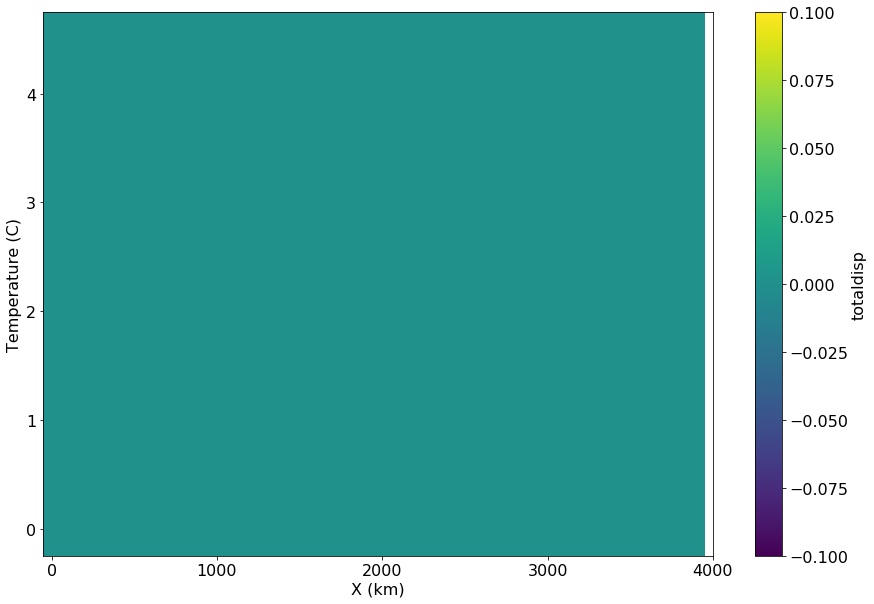

In [10]:
(dd1yr.totaldisp - dd.totaldisp).mean(dim='y').plot()
plt.yticks(range(0,np.size(temps),2),[0, 1 ,2,3,4,5])
plt.xticks([0,10,20,30, 40],[0, 1000, 2000, 3000, 4000])
plt.xlabel('X (km)')
plt.ylabel('Temperature (C)')

year1 = dd1yr.totaldisp.mean(dim='y')
year2 = dd.totaldisp.mean(dim='y')

fractional = xr.ufuncs.sqrt(((year1-year2)*(year1-year2)).mean(dim=['x','T']))
#typicalrms = xr.ufuncs.sqrt((year1*year1).mean(dim=['x','T']))
typicalrms = xr.ufuncs.sqrt((year2*year2).mean(dim=['x','T']))

meanfractional = fractional/typicalrms
print(typicalrms)
print(fractional)
print(meanfractional)